## 1. Import Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import sys
warnings.filterwarnings('ignore')

# For time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For Prophet
try:
    from prophet import Prophet
    prophet_available = True
except ImportError:
    prophet_available = False
    print("Prophet not installed. Install with: pip install prophet")

# For LSTM
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore Data

In [32]:
# Load the data
df = pd.read_csv('openmeteo_weather_data_daily.csv')

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'])

# Set time as index
df.set_index('time', inplace=True)

# Display basic information
print("Dataset shape:", df.shape)
print("\nDate range:", df.index.min(), "to", df.index.max())
print("\nColumns:", df.columns.tolist())
print("\n" + "="*50)
print("First few rows:")
df.head(10)

Dataset shape: (1431, 7)

Date range: 2022-01-01 00:00:00 to 2025-12-01 00:00:00

Columns: ['weather_code', 'temperature_max', 'temperature_min', 'precipitation', 'wind_speed_max', 'wind_gust_max', 'solar_ghi_sum']

First few rows:


,weather_code,temperature_max,temperature_min,precipitation,wind_speed_max,wind_gust_max,solar_ghi_sum
time,,,,,,,
2022-01-01,55,31.7,22.5,2.8,15.0,32.4,18.22
2022-01-02,61,31.1,22.8,2.7,16.9,38.9,18.03
2022-01-03,55,30.9,22.6,2.4,16.8,41.0,17.59
2022-01-04,55,30.5,22.4,1.1,21.0,43.9,18.51
2022-01-05,53,29.4,23.0,2.0,17.2,38.2,17.08
2022-01-06,51,31.6,22.8,0.1,19.5,42.5,18.57
2022-01-07,53,33.0,22.2,1.5,13.6,32.0,20.62
2022-01-08,51,31.5,21.4,0.2,16.8,36.7,20.23
2022-01-09,3,31.8,22.7,0.0,15.3,35.6,20.20


In [15]:
# Check for missing values and basic statistics
print("Missing values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nBasic statistics for solar_ghi_sum:")
print(df['solar_ghi_sum'].describe())
print("\nData type:", df['solar_ghi_sum'].dtype)

Missing values:
weather_code       0
temperature_max    0
temperature_min    0
precipitation      0
wind_speed_max     0
wind_gust_max      0
solar_ghi_sum      0
dtype: int64


Basic statistics for solar_ghi_sum:
count    1431.000000
mean       18.460245
std         4.316332
min         2.140000
25%        15.710000
50%        19.150000
75%        21.735000
max        26.760000
Name: solar_ghi_sum, dtype: float64

Data type: float64


## 3. Data Visualization

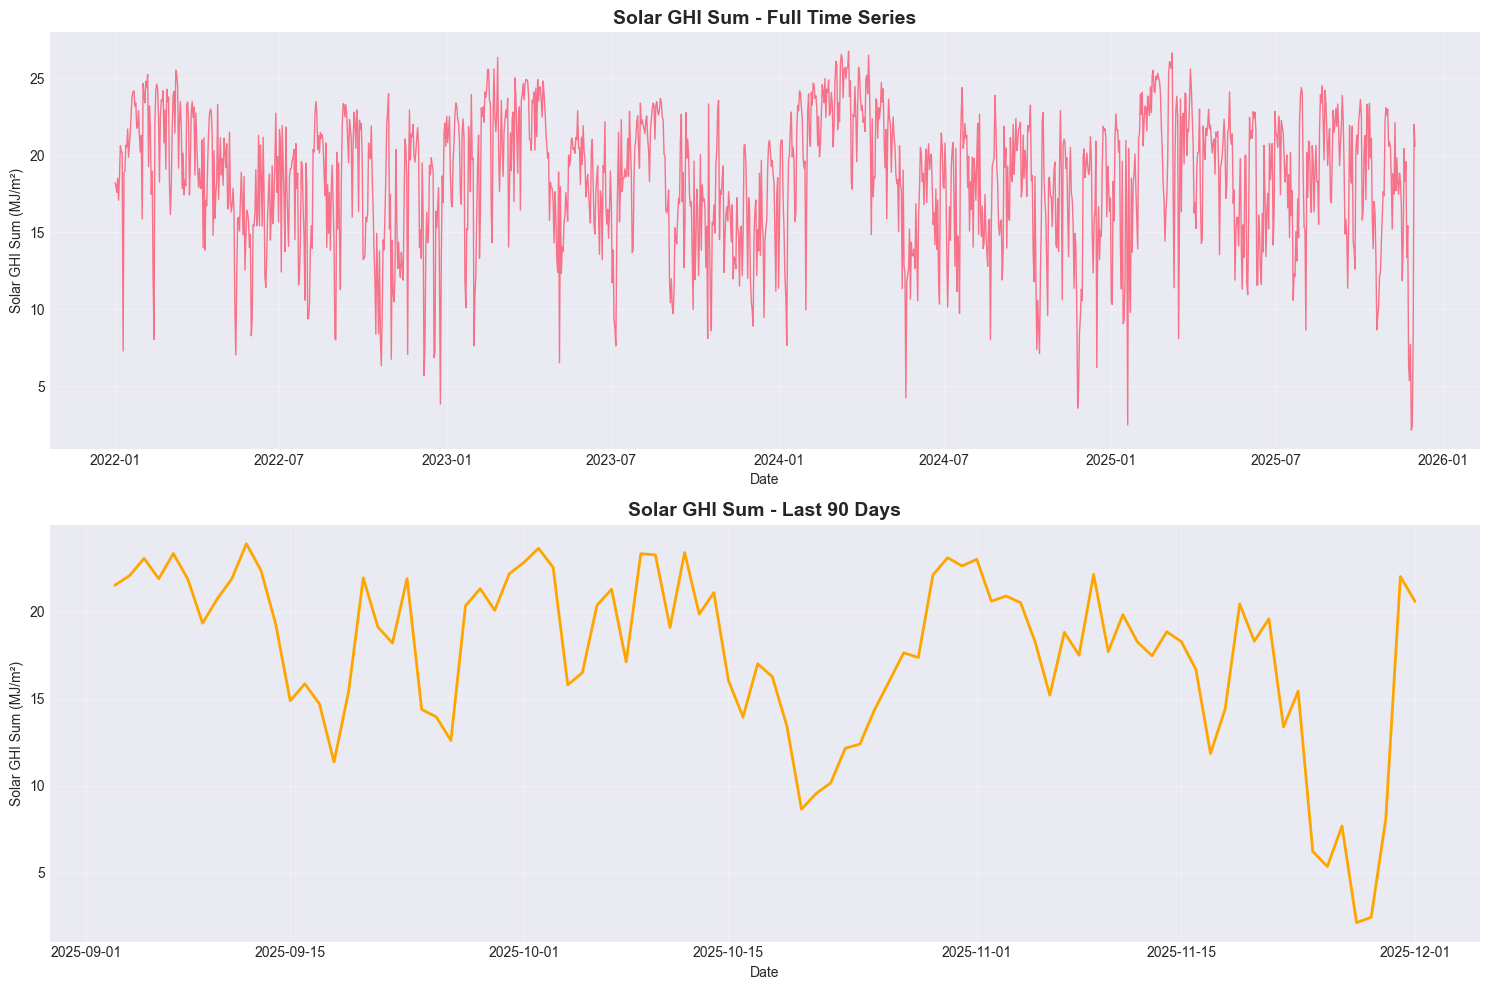

In [16]:
# Plot the time series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full time series
axes[0].plot(df.index, df['solar_ghi_sum'], linewidth=1)
axes[0].set_title('Solar GHI Sum - Full Time Series', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Solar GHI Sum (MJ/m²)')
axes[0].grid(True, alpha=0.3)

# Recent data (last 90 days)
recent_data = df['solar_ghi_sum'].tail(90)
axes[1].plot(recent_data.index, recent_data, linewidth=2, color='orange')
axes[1].set_title('Solar GHI Sum - Last 90 Days', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Solar GHI Sum (MJ/m²)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

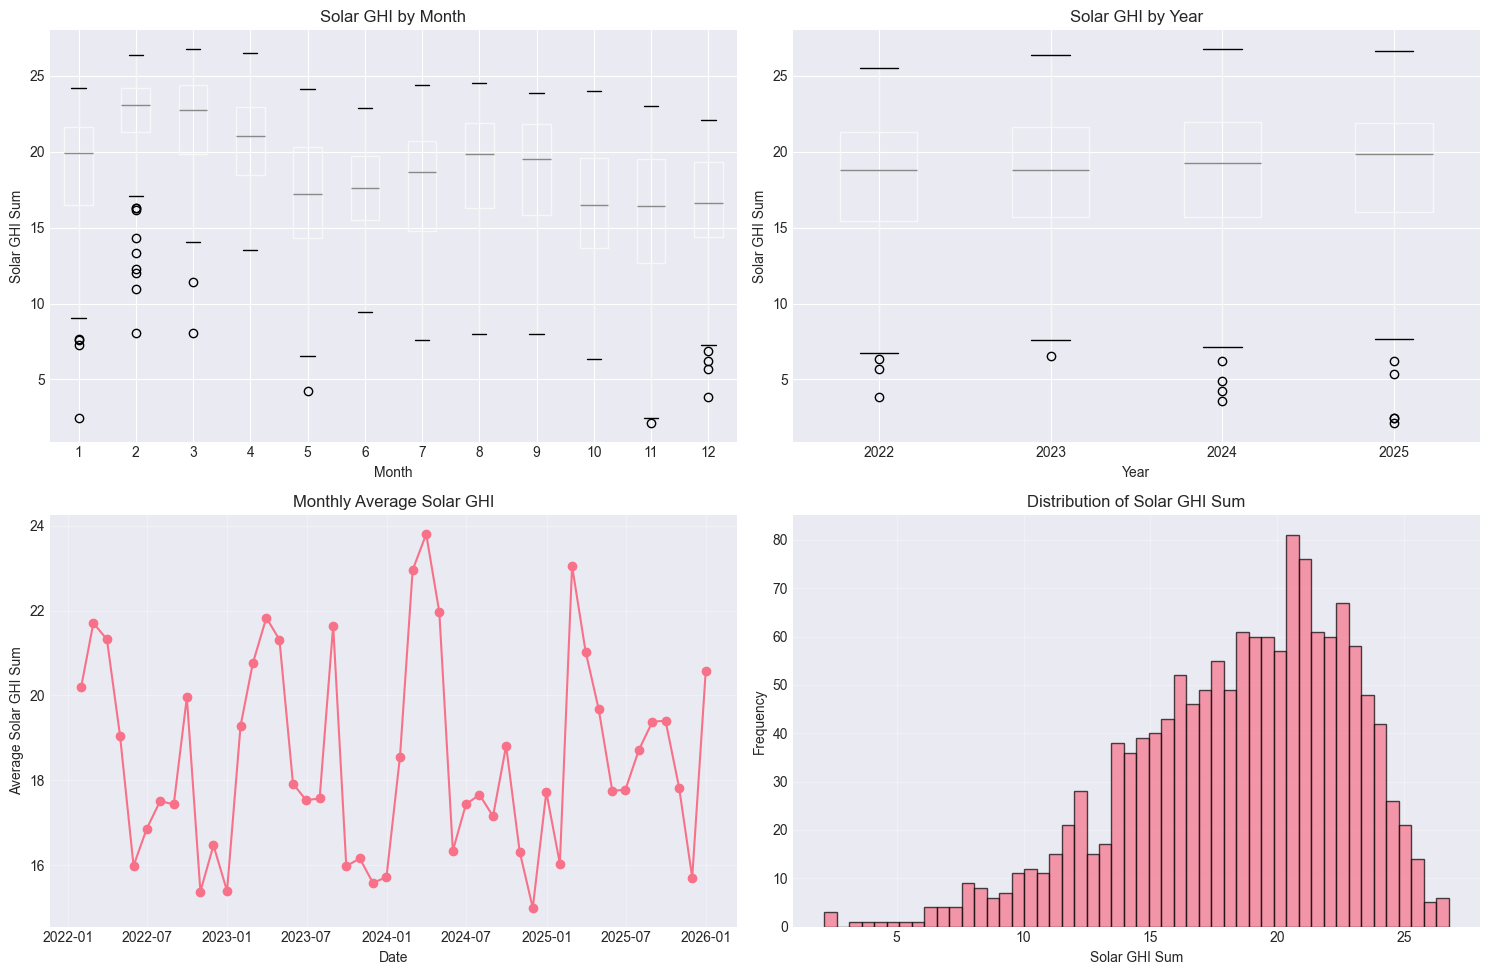

In [17]:
# Monthly and seasonal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Box plot by month
df_with_month = df.copy()
df_with_month['month'] = df_with_month.index.month
df_with_month.boxplot(column='solar_ghi_sum', by='month', ax=axes[0, 0])
axes[0, 0].set_title('Solar GHI by Month')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Solar GHI Sum')

# Box plot by year
df_with_month['year'] = df_with_month.index.year
df_with_month.boxplot(column='solar_ghi_sum', by='year', ax=axes[0, 1])
axes[0, 1].set_title('Solar GHI by Year')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Solar GHI Sum')

# Monthly average
monthly_avg = df['solar_ghi_sum'].resample('M').mean()
axes[1, 0].plot(monthly_avg.index, monthly_avg, marker='o')
axes[1, 0].set_title('Monthly Average Solar GHI')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Average Solar GHI Sum')
axes[1, 0].grid(True, alpha=0.3)

# Distribution
axes[1, 1].hist(df['solar_ghi_sum'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Solar GHI Sum')
axes[1, 1].set_xlabel('Solar GHI Sum')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('')
plt.tight_layout()
plt.show()

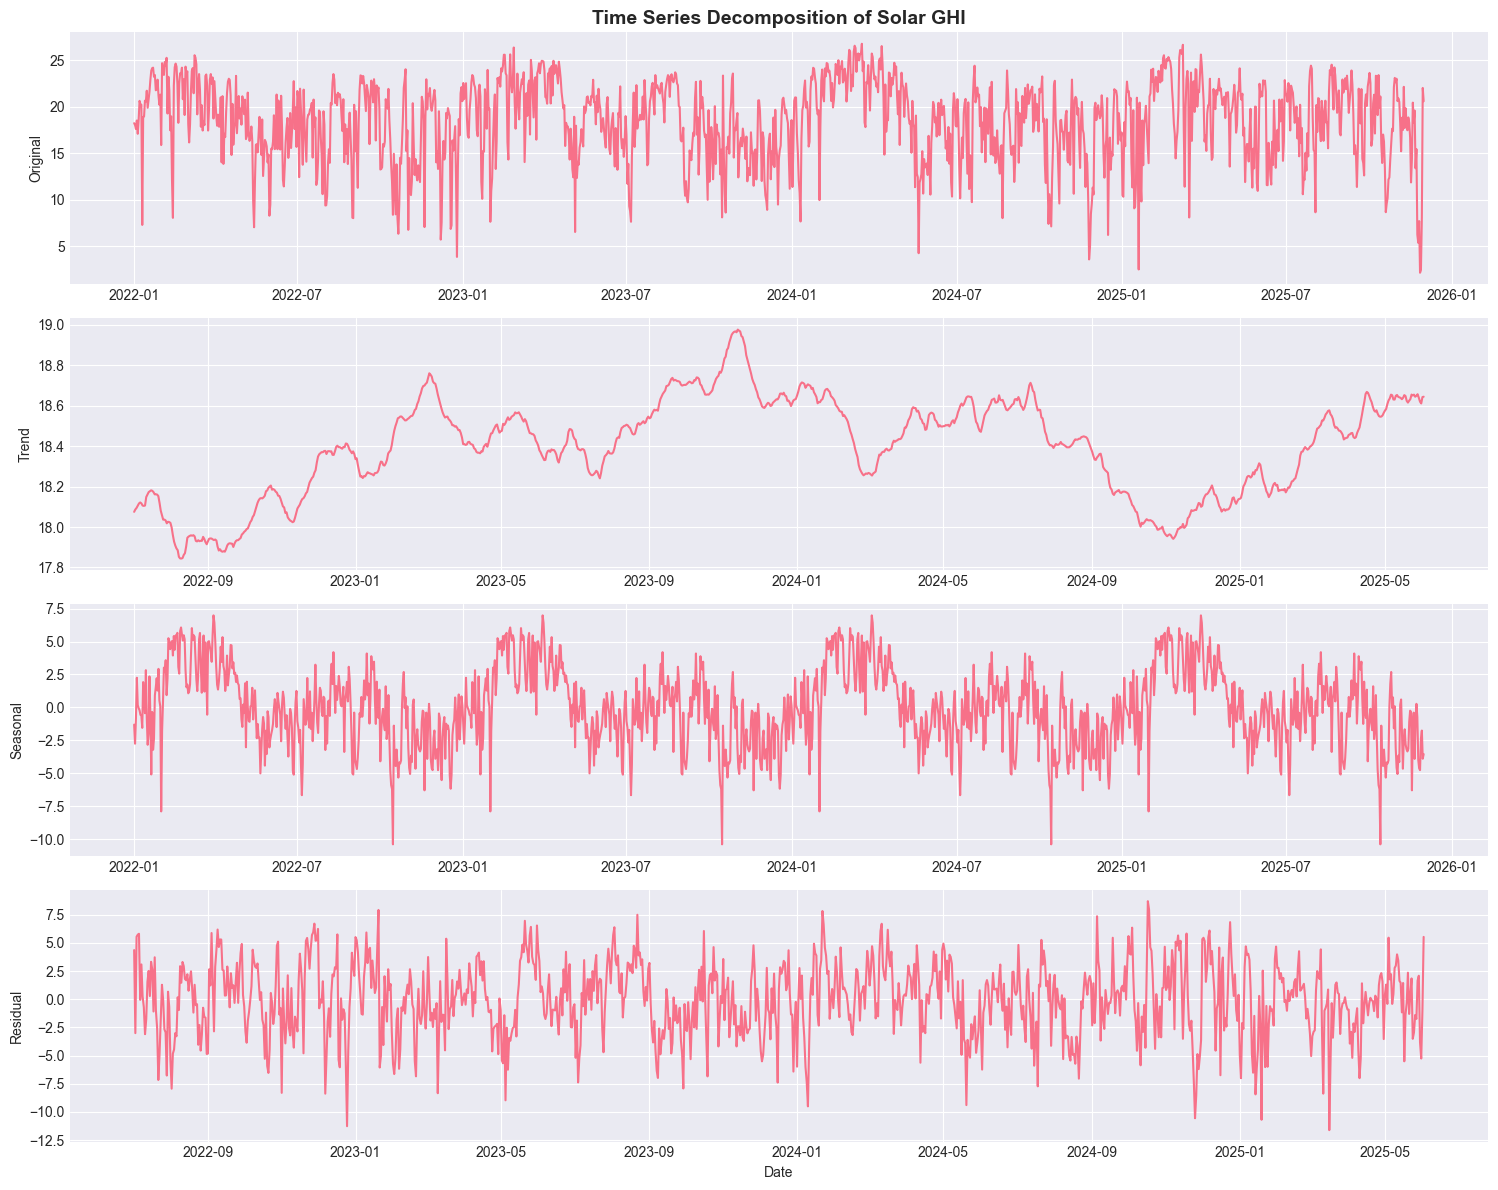

In [18]:
# Time series decomposition
decomposition = seasonal_decompose(df['solar_ghi_sum'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original
axes[0].plot(df.index, df['solar_ghi_sum'])
axes[0].set_ylabel('Original')
axes[0].set_title('Time Series Decomposition of Solar GHI', fontsize=14, fontweight='bold')

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend)
axes[1].set_ylabel('Trend')

# Seasonal
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal)
axes[2].set_ylabel('Seasonal')

# Residual
axes[3].plot(decomposition.resid.index, decomposition.resid)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

## 4. Stationarity Test

ADF Statistic: -10.891975543625609
p-value: 1.218647705362764e-19
Critical Values:
	1%: -3.4349408214067227
	5%: -2.8635675309927153
	10%: -2.5678494453155656

✓ Series is stationary (reject null hypothesis)


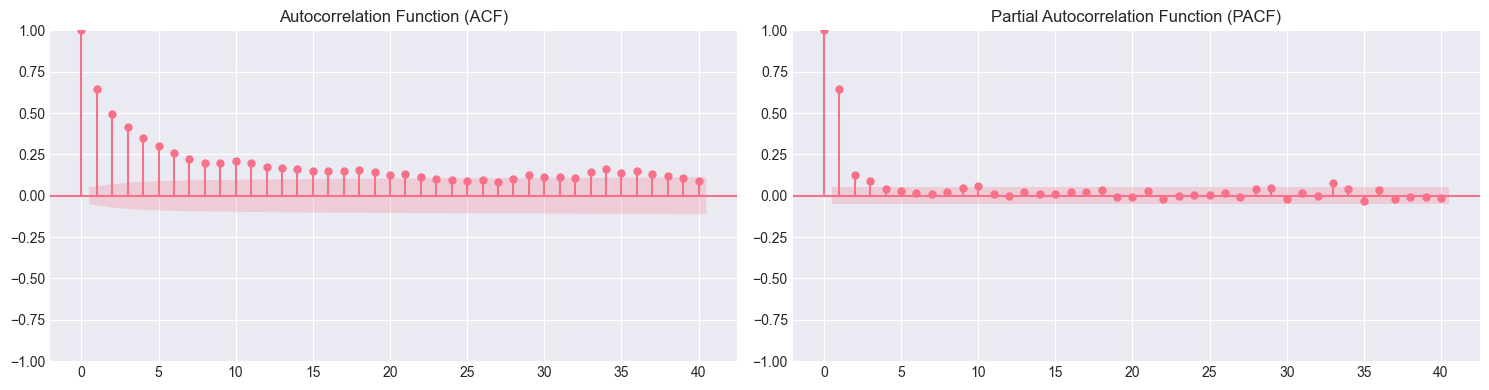

In [19]:
# Augmented Dickey-Fuller test
result = adfuller(df['solar_ghi_sum'].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')
    
if result[1] <= 0.05:
    print("\n✓ Series is stationary (reject null hypothesis)")
else:
    print("\n✗ Series is non-stationary (fail to reject null hypothesis)")

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

plot_acf(df['solar_ghi_sum'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(df['solar_ghi_sum'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## 5. Train-Test Split

Training set: 1144 samples (2022-01-01 00:00:00 to 2025-02-17 00:00:00)
Test set: 287 samples (2025-02-18 00:00:00 to 2025-12-01 00:00:00)


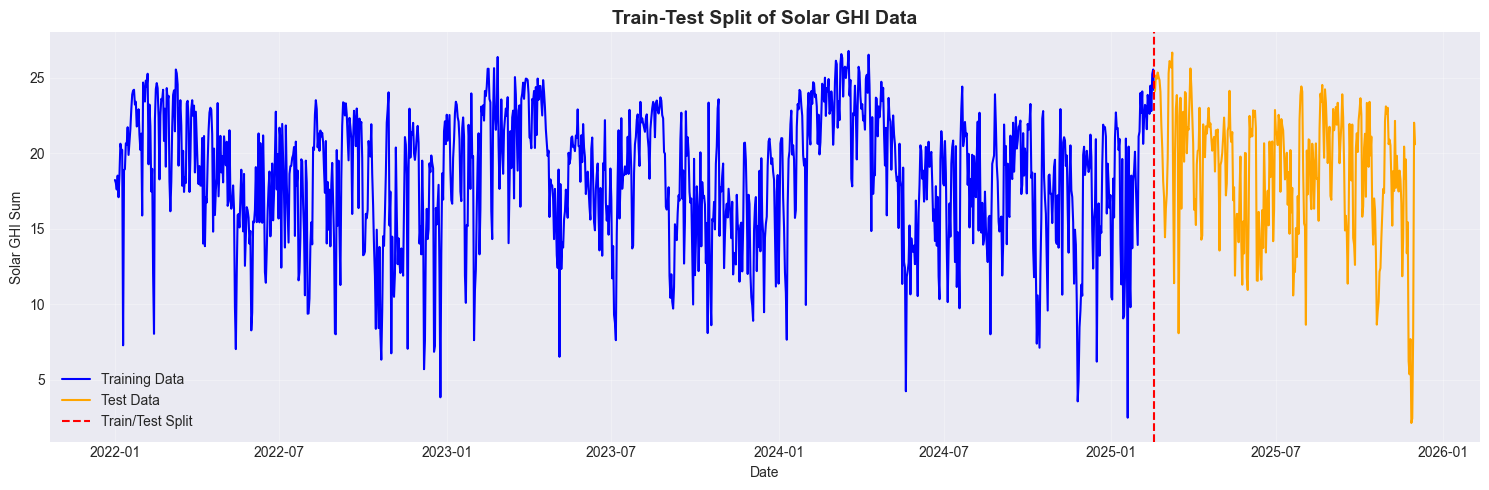

In [33]:
# Split data into train and test sets (80-20 split)
train_size = int(len(df) * 0.8)
train_data = df['solar_ghi_sum'][:train_size]
test_data = df['solar_ghi_sum'][train_size:]

print(f"Training set: {len(train_data)} samples ({train_data.index.min()} to {train_data.index.max()})")
print(f"Test set: {len(test_data)} samples ({test_data.index.min()} to {test_data.index.max()})")

# Visualize the split
plt.figure(figsize=(15, 5))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.axvline(x=train_data.index[-1], color='red', linestyle='--', label='Train/Test Split')
plt.title('Train-Test Split of Solar GHI Data', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Solar GHI Sum')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Model 1: Enhanced Auto SARIMA with Multiple Seasonality Options
**Improved with grid search, cross-validation, and optimized parameters**

In [34]:
# Enhanced Auto ARIMA with multiple seasonality trials and cross-validation
from pmdarima import auto_arima
import time

print("="*70)
print("🔍 Enhanced SARIMA Model with Grid Search")
print("Testing multiple seasonality patterns for optimal performance")
print("This will take approximately 5-15 minutes")
print("="*70)

start_time = time.time()

# Try multiple seasonal periods and compare
seasonality_options = [
    {'m': 7, 'name': 'Weekly'},
    {'m': 30, 'name': 'Monthly'},
]

best_aic = float('inf')
best_model = None
best_config = None

for season_config in seasonality_options:
    print(f"\n{'='*60}")
    print(f"Testing {season_config['name']} Seasonality (m={season_config['m']})")
    print(f"{'='*60}")
    
    try:
        sarima_candidate = auto_arima(
            train_data,
            start_p=1, start_q=1,
            max_p=5, max_q=5,  # Increased range for better fit
            m=season_config['m'],
            start_P=0, start_Q=0,
            max_P=2, max_Q=2,
            seasonal=True,
            d=None, D=None,
            trace=False,  # Less verbose for multiple runs
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True,
            n_jobs=-1,
            information_criterion='aic',
            maxiter=100,
            out_of_sample_size=int(len(train_data) * 0.1)  # 10% validation
        )
        
        current_aic = sarima_candidate.aic()
        print(f"Order: {sarima_candidate.order}")
        print(f"Seasonal Order: {sarima_candidate.seasonal_order}")
        print(f"AIC: {current_aic:.2f}")
        
        if current_aic < best_aic:
            best_aic = current_aic
            best_model = sarima_candidate
            best_config = season_config
            print("✓ New best model found!")
    except Exception as e:
        print(f"✗ Failed: {str(e)}")
        continue

elapsed_time = time.time() - start_time

print("\n" + "="*70)
print("🏆 OPTIMAL MODEL SELECTED")
print("="*70)
print(f"Best Seasonality: {best_config['name']} (m={best_config['m']})")
print(f"Best SARIMA order: {best_model.order}")
print(f"Best seasonal order: {best_model.seasonal_order}")
print(f"AIC: {best_aic:.2f}")
print(f"BIC: {best_model.bic():.2f}")
print(f"Training time: {elapsed_time/60:.2f} minutes")
print("="*70)

sarima_result = best_model
print("\n" + "="*50)
print("Detailed Model Summary:")
print("="*50)
print(sarima_result.summary())

🔍 Enhanced SARIMA Model with Grid Search
Testing multiple seasonality patterns for optimal performance
This will take approximately 5-15 minutes

Testing Weekly Seasonality (m=7)
Order: (4, 0, 1)
Seasonal Order: (0, 0, 0, 7)
AIC: 5941.24
✓ New best model found!

Testing Monthly Seasonality (m=30)
Order: (4, 0, 1)
Seasonal Order: (0, 0, 0, 30)
AIC: 5941.24

🏆 OPTIMAL MODEL SELECTED
Best Seasonality: Weekly (m=7)
Best SARIMA order: (4, 0, 1)
Best seasonal order: (0, 0, 0, 7)
AIC: 5941.24
BIC: 5976.53
Training time: 2.67 minutes

Detailed Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1144
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -2963.618
Date:                Thu, 01 Jan 2026   AIC                           5941.236
Time:                        14:17:20   BIC                           5976.532
Sample:                             0   HQIC    


📊 SARIMA Model Performance:
MAE (Mean Absolute Error):      3.3461
RMSE (Root Mean Squared Error): 4.1447
MAPE (Mean Abs % Error):        25.59%
Accuracy:                       74.41%
R² Score:                       0.0592


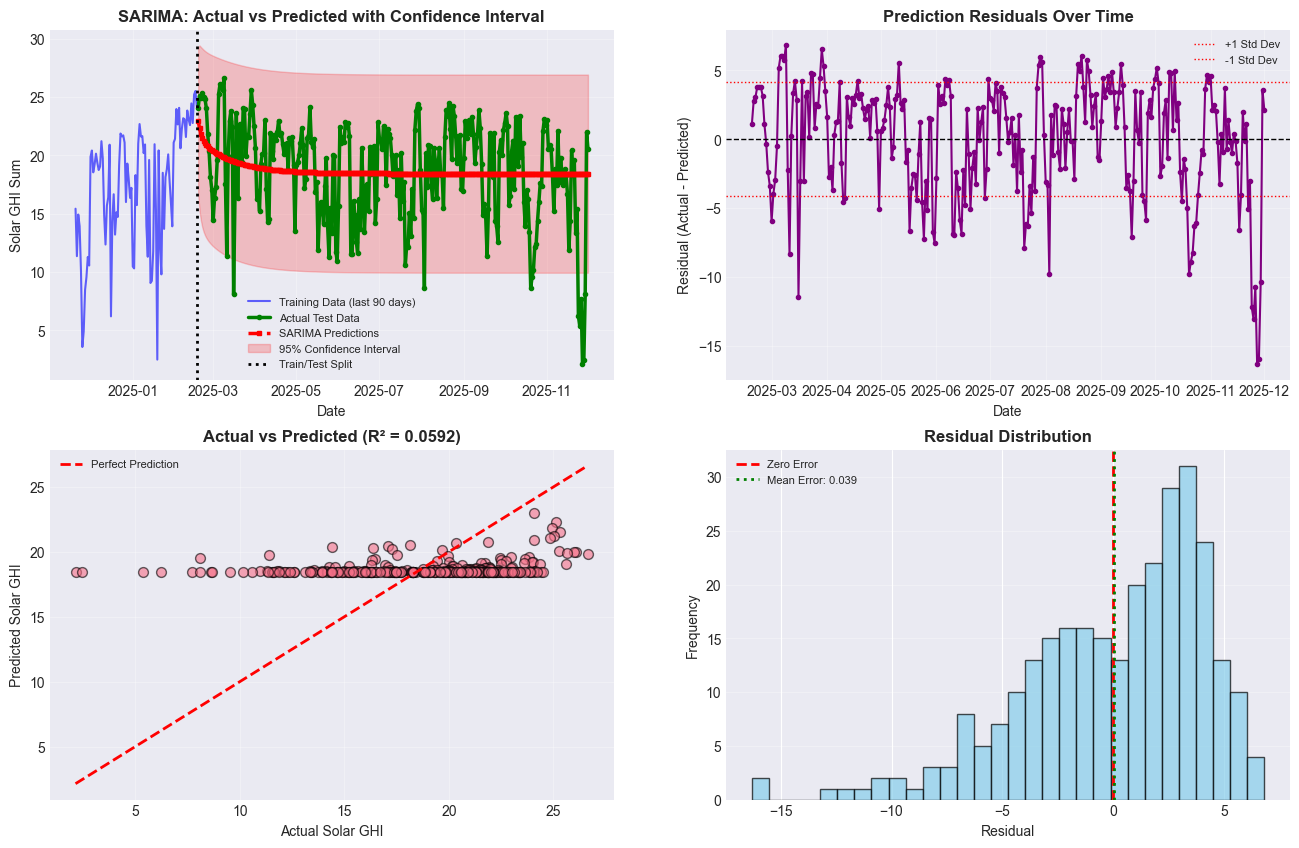

<Figure size 640x480 with 0 Axes>

In [54]:
# Make predictions on test set with confidence intervals
sarima_forecast = sarima_result.predict(n_periods=len(test_data), return_conf_int=True)
sarima_predictions = sarima_forecast[0]  # Point forecasts
sarima_conf_int = sarima_forecast[1]  # Confidence intervals

# Calculate metrics
sarima_mae = mean_absolute_error(test_data, sarima_predictions)
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_predictions))
sarima_r2 = r2_score(test_data, sarima_predictions)
sarima_mape = np.mean(np.abs((test_data.values - sarima_predictions) / test_data.values)) * 100
sarima_accuracy = 100 - sarima_mape

print("\n" + "="*70)
print("📊 SARIMA Model Performance:")
print("="*70)
print(f"MAE (Mean Absolute Error):      {sarima_mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {sarima_rmse:.4f}")
print(f"MAPE (Mean Abs % Error):        {sarima_mape:.2f}%")
print(f"Accuracy:                       {sarima_accuracy:.2f}%")
print(f"R² Score:                       {sarima_r2:.4f}")
print("="*70)

# Enhanced visualization with multiple plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Full comparison with confidence interval
axes[0, 0].plot(train_data.index[-90:], train_data[-90:], label='Training Data (last 90 days)', 
                color='blue', alpha=0.6, linewidth=1.5)
axes[0, 0].plot(test_data.index, test_data, label='Actual Test Data', 
                color='green', linewidth=2.5, marker='o', markersize=3)
axes[0, 0].plot(test_data.index, sarima_predictions, label='SARIMA Predictions', 
                color='red', linewidth=2.5, linestyle='--', marker='s', markersize=3)
axes[0, 0].fill_between(test_data.index, 
                         sarima_conf_int[:, 0], sarima_conf_int[:, 1], 
                         alpha=0.2, color='red', label='95% Confidence Interval')
axes[0, 0].axvline(x=train_data.index[-1], color='black', linestyle=':', linewidth=2, label='Train/Test Split')
axes[0, 0].set_title('SARIMA: Actual vs Predicted with Confidence Interval', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Solar GHI Sum')
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals over time
residuals = test_data.values - sarima_predictions
axes[0, 1].plot(test_data.index, residuals, color='purple', linewidth=1.5, marker='o', markersize=3)
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].axhline(y=residuals.std(), color='red', linestyle=':', linewidth=1, label='+1 Std Dev')
axes[0, 1].axhline(y=-residuals.std(), color='red', linestyle=':', linewidth=1, label='-1 Std Dev')
axes[0, 1].set_title('Prediction Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Residual (Actual - Predicted)')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Scatter plot of actual vs predicted
axes[1, 0].scatter(test_data.values, sarima_predictions, alpha=0.6, s=50, edgecolor='black')
axes[1, 0].plot([test_data.min(), test_data.max()], [test_data.min(), test_data.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title(f'Actual vs Predicted (R² = {sarima_r2:.4f})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual Solar GHI')
axes[1, 0].set_ylabel('Predicted Solar GHI')
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residual distribution
axes[1, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].axvline(x=residuals.mean(), color='green', linestyle=':', linewidth=2, 
                    label=f'Mean Error: {residuals.mean():.3f}')
axes[1, 1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.show()
plt.tight_layout()

## 7. Model 2: Enhanced Prophet with Custom Seasonality & Hyperparameter Tuning
**Improved with grid search and custom seasonality patterns**

In [36]:
if prophet_available:
    print("="*70)
    print("🔍 Enhanced Prophet Model with Hyperparameter Tuning")
    print("="*70)
    
    # Prepare data for Prophet
    prophet_train = pd.DataFrame({
        'ds': train_data.index,
        'y': train_data.values
    })
    
    # Grid search for best Prophet parameters
    param_grid = [
        {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 
         'seasonality_mode': 'multiplicative', 'name': 'Conservative'},
        {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 
         'seasonality_mode': 'multiplicative', 'name': 'Balanced'},
        {'changepoint_prior_scale': 5.0, 'seasonality_prior_scale': 10, 
         'seasonality_mode': 'additive', 'name': 'Flexible'},
    ]
    
    best_mae = float('inf')
    best_prophet_model = None
    best_params = None
    
    print("\nTesting different hyperparameter configurations...\n")
    
    for params in param_grid:
        print(f"Testing {params['name']} configuration...")
        
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],

            seasonality_mode=params['seasonality_mode'],
            interval_width=0.95
        )
        
        # Add custom monthly seasonality
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        model.fit(prophet_train)
        
        # Predict and evaluate
        future = model.make_future_dataframe(periods=len(test_data), freq='D')
        forecast = model.predict(future)
        predictions = forecast.iloc[-len(test_data):]['yhat'].values
        mae = mean_absolute_error(test_data, predictions)
        print(f"  MAE: {mae:.4f}")
        
        if mae < best_mae:
            best_mae = mae
            best_prophet_model = model
            best_params = params
            print("  ✓ Best model so far!")
        print()
    
    print("="*70)
    print("🏆 OPTIMAL PROPHET MODEL SELECTED")
    print("="*70)
    print(f"Best Configuration: {best_params['name']}")
    print(f"Changepoint Prior Scale: {best_params['changepoint_prior_scale']}")
    print(f"Seasonality Prior Scale: {best_params['seasonality_prior_scale']}")
    print(f"Seasonality Mode: {best_params['seasonality_mode']}")
    print("="*70)
    
    # Use best model
    prophet_model = best_prophet_model
    future = prophet_model.make_future_dataframe(periods=len(test_data), freq='D')
    forecast = prophet_model.predict(future)
    
    prophet_predictions = forecast.iloc[-len(test_data):]['yhat'].values
    prophet_lower = forecast.iloc[-len(test_data):]['yhat_lower'].values
    prophet_upper = forecast.iloc[-len(test_data):]['yhat_upper'].values
    
    # Calculate metrics
    prophet_mae = mean_absolute_error(test_data, prophet_predictions)
    prophet_rmse = np.sqrt(mean_squared_error(test_data, prophet_predictions))
    prophet_r2 = r2_score(test_data, prophet_predictions)
    prophet_mape = np.mean(np.abs((test_data.values - prophet_predictions) / test_data.values)) * 100
    
    print("\n📊 Enhanced Prophet Model Performance:")
    print("="*50)
    print(f"MAE:   {prophet_mae:.4f}")
    print(f"RMSE:  {prophet_rmse:.4f}")
    print(f"R²:    {prophet_r2:.4f}")
    print(f"MAPE:  {prophet_mape:.2f}%")
    print("="*50)
else:
    print("Prophet is not available. Install with: pip install prophet")

14:17:32 - cmdstanpy - INFO - Chain [1] start processing


🔍 Enhanced Prophet Model with Hyperparameter Tuning

Testing different hyperparameter configurations...

Testing Conservative configuration...


14:17:32 - cmdstanpy - INFO - Chain [1] done processing
14:17:32 - cmdstanpy - INFO - Chain [1] start processing


  MAE: 3.4267
  ✓ Best model so far!

Testing Balanced configuration...


14:17:33 - cmdstanpy - INFO - Chain [1] done processing
14:17:33 - cmdstanpy - INFO - Chain [1] start processing


  MAE: 3.4597

Testing Flexible configuration...


14:17:34 - cmdstanpy - INFO - Chain [1] done processing


  MAE: 3.8422

🏆 OPTIMAL PROPHET MODEL SELECTED
Best Configuration: Conservative
Changepoint Prior Scale: 0.05
Seasonality Prior Scale: 10
Seasonality Mode: multiplicative

📊 Enhanced Prophet Model Performance:
MAE:   3.4267
RMSE:  4.2509
R²:    0.0103
MAPE:  24.33%


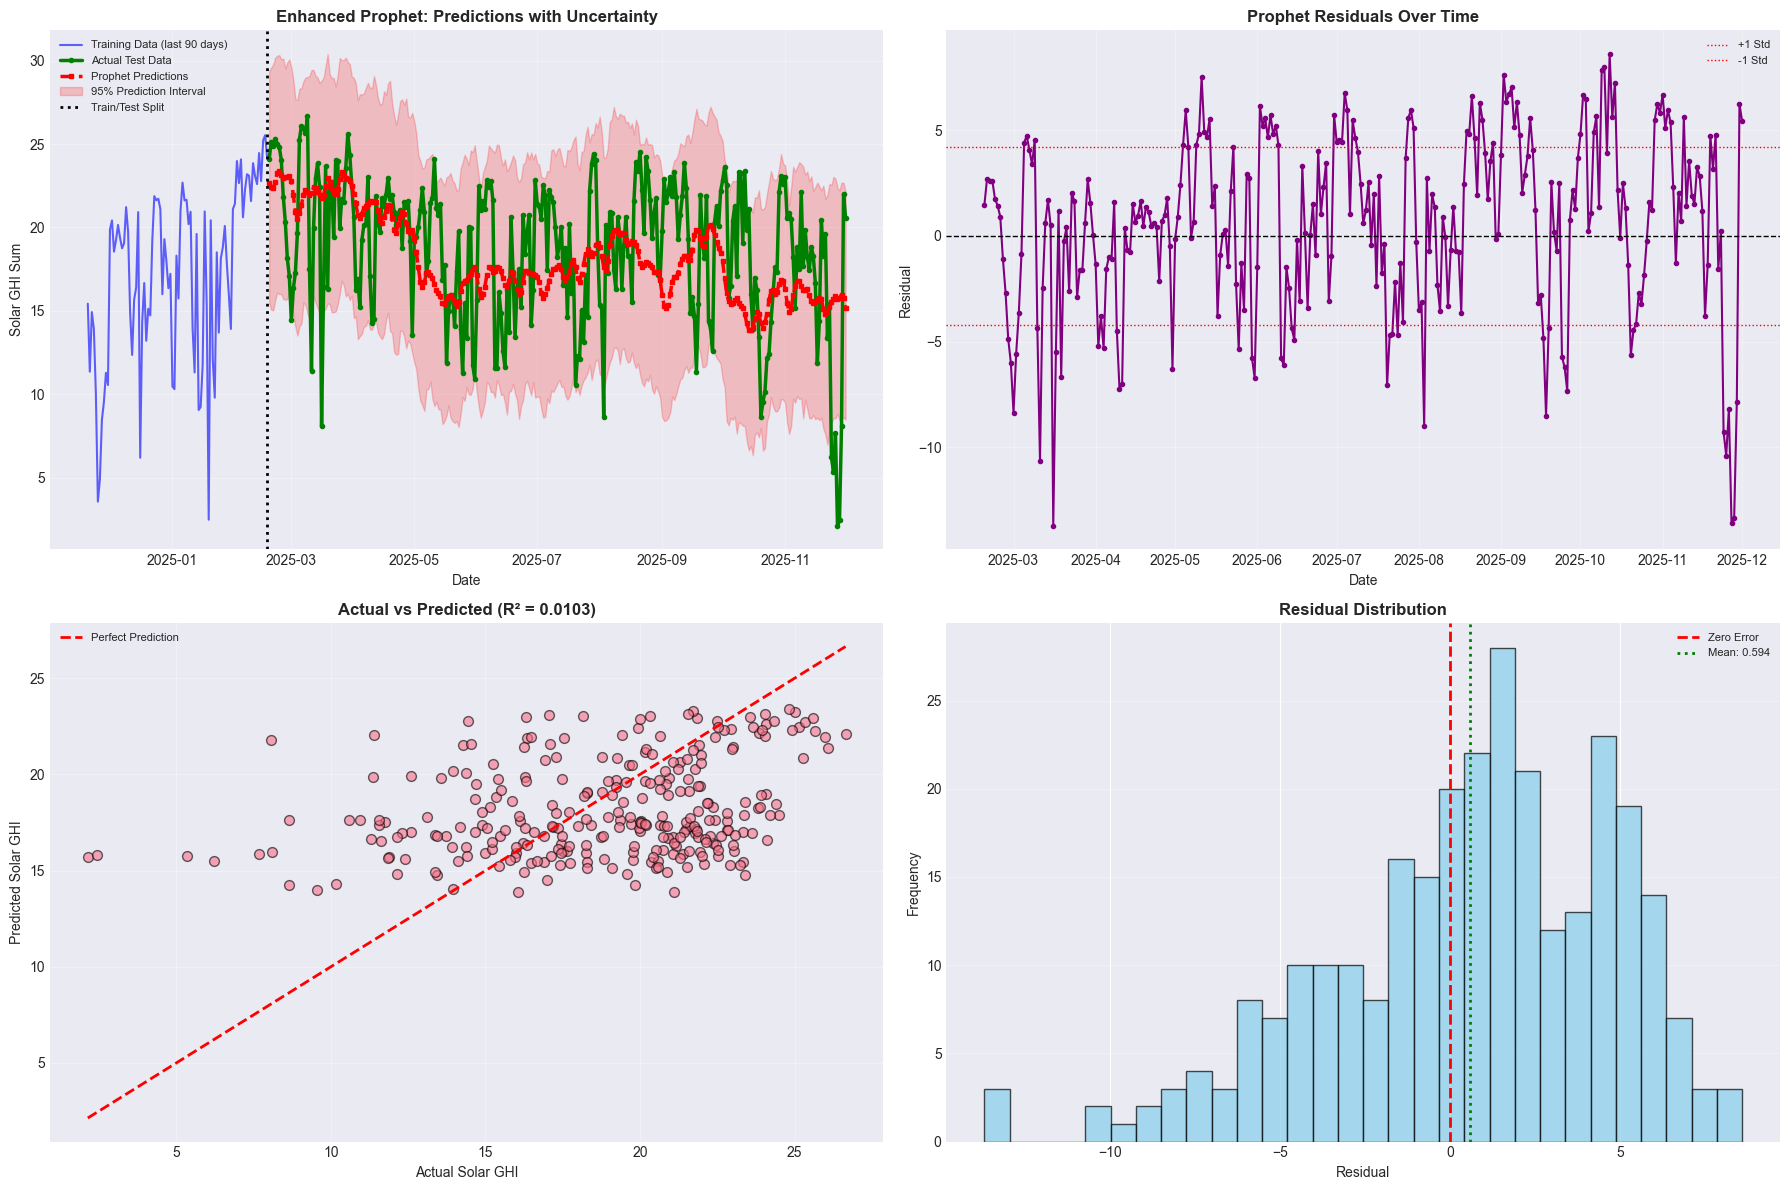

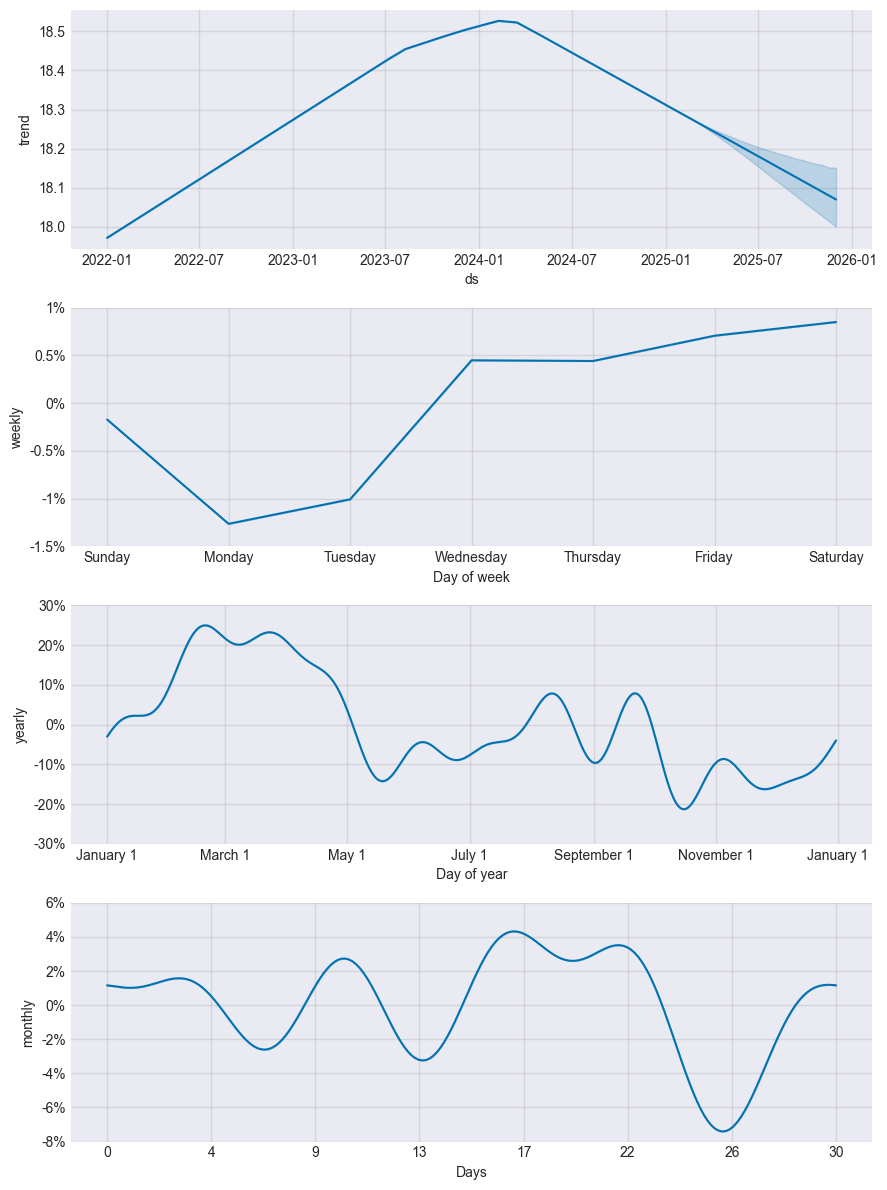

In [37]:
if prophet_available:
    # Enhanced visualization with 4 detailed plots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot 1: Predictions with confidence intervals
    axes[0, 0].plot(train_data.index[-90:], train_data[-90:], 
                    label='Training Data (last 90 days)', color='blue', alpha=0.6, linewidth=1.5)
    axes[0, 0].plot(test_data.index, test_data, 
                    label='Actual Test Data', color='green', linewidth=2.5, marker='o', markersize=3)
    axes[0, 0].plot(test_data.index, prophet_predictions, 
                    label='Prophet Predictions', color='red', linewidth=2.5, linestyle='--', marker='s', markersize=3)
    axes[0, 0].fill_between(test_data.index, prophet_lower, prophet_upper, 
                            alpha=0.2, color='red', label='95% Prediction Interval')
    axes[0, 0].axvline(x=train_data.index[-1], color='black', linestyle=':', linewidth=2, label='Train/Test Split')
    axes[0, 0].set_title('Enhanced Prophet: Predictions with Uncertainty', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Solar GHI Sum')
    axes[0, 0].legend(fontsize=8)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Residuals
    prophet_residuals = test_data.values - prophet_predictions
    axes[0, 1].plot(test_data.index, prophet_residuals, color='purple', linewidth=1.5, marker='o', markersize=3)

    axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[0, 1].axhline(y=prophet_residuals.std(), color='red', linestyle=':', linewidth=1, label='+1 Std')
    axes[0, 1].axhline(y=-prophet_residuals.std(), color='red', linestyle=':', linewidth=1, label='-1 Std')
    axes[0, 1].set_title('Prophet Residuals Over Time', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Residual')
    axes[0, 1].legend(fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Scatter plot
    axes[1, 0].scatter(test_data.values, prophet_predictions, alpha=0.6, s=50, edgecolor='black')
    axes[1, 0].plot([test_data.min(), test_data.max()], [test_data.min(), test_data.max()], 
                    'r--', linewidth=2, label='Perfect Prediction')
    axes[1, 0].set_title(f'Actual vs Predicted (R² = {prophet_r2:.4f})', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Actual Solar GHI')
    axes[1, 0].set_ylabel('Predicted Solar GHI')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Residual distribution
    axes[1, 1].hist(prophet_residuals, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[1, 1].axvline(x=prophet_residuals.mean(), color='green', linestyle=':', linewidth=2, 
                       label=f'Mean: {prophet_residuals.mean():.3f}')
    axes[1, 1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Residual')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend(fontsize=8)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Plot components
    fig = prophet_model.plot_components(forecast)
    plt.show()
else:
    print("Prophet is not available.")

## 8. Model 3: LSTM (Long Short-Term Memory)

In [68]:
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['solar_ghi_sum'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Use 30 days of history to predict next day
seq_length = 50
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

print(f"Training sequences: {X_train_tensor.shape}")
print(f"Test sequences: {X_test_tensor.shape}")

Training sequences: torch.Size([1104, 50, 1])
Test sequences: torch.Size([277, 50, 1])


In [69]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

🔍 Enhanced LSTM Model with Hyperparameter Tuning
Testing multiple configurations for optimal performance

Testing Baseline Configuration
Hidden Size: 50, Layers: 2, Dropout: 0.2
Learning Rate: 0.001, Epochs: 100
Validation MAE: 2.6857
Final Training Loss: 0.017393
✓ New best model found!

Testing Increased Hidden Configuration
Hidden Size: 64, Layers: 2, Dropout: 0.3
Learning Rate: 0.001, Epochs: 100
Validation MAE: 2.6661
Final Training Loss: 0.017069
✓ New best model found!

Testing Deeper Network Configuration
Hidden Size: 50, Layers: 3, Dropout: 0.3
Learning Rate: 0.0005, Epochs: 120
Validation MAE: 2.6811
Final Training Loss: 0.017305

Testing Large Hidden Configuration
Hidden Size: 100, Layers: 2, Dropout: 0.25
Learning Rate: 0.001, Epochs: 100
Validation MAE: 2.7179
Final Training Loss: 0.017033

🏆 OPTIMAL LSTM MODEL SELECTED
Best Configuration: Increased Hidden
Hidden Size: 64
Number of Layers: 2
Dropout: 0.3
Learning Rate: 0.001
Validation MAE: 2.6661


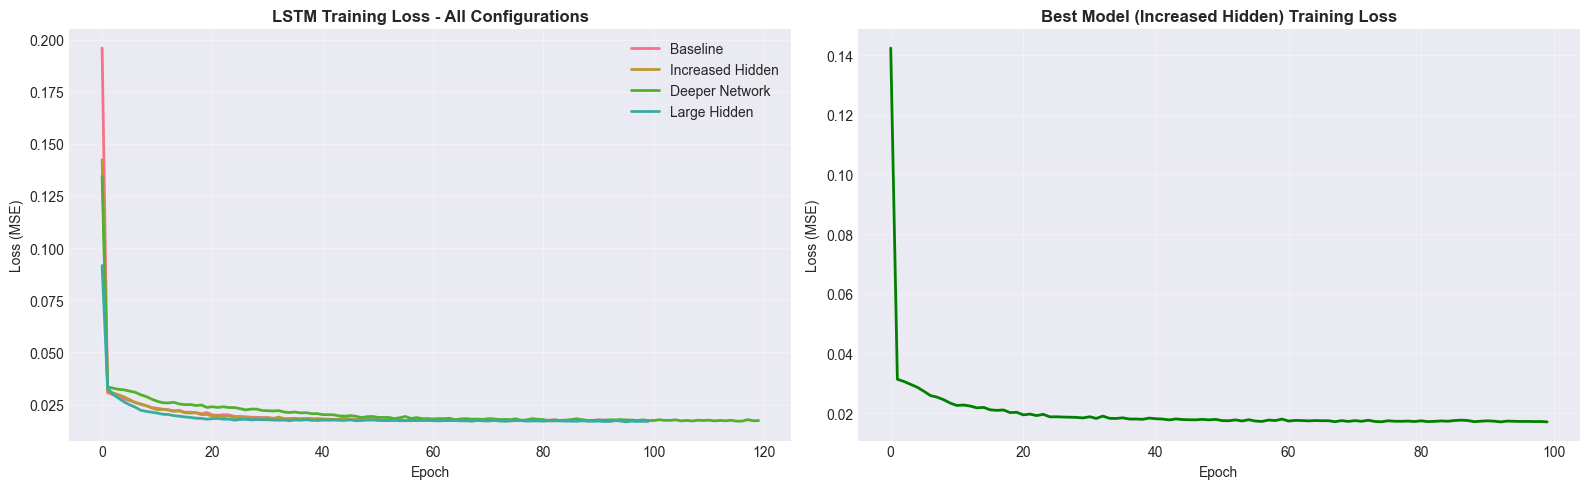

In [70]:
# Enhanced LSTM with Hyperparameter Tuning
print("="*70)
print("🔍 Enhanced LSTM Model with Hyperparameter Tuning")
print("Testing multiple configurations for optimal performance")
print("="*70)

# Grid search configurations
param_grid = [
    {'hidden_size': 50, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'epochs': 100, 'name': 'Baseline'},
    {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001, 'epochs': 100, 'name': 'Increased Hidden'},
    {'hidden_size': 50, 'num_layers': 3, 'dropout': 0.3, 'lr': 0.0005, 'epochs': 120, 'name': 'Deeper Network'},
    {'hidden_size': 100, 'num_layers': 2, 'dropout': 0.25, 'lr': 0.001, 'epochs': 100, 'name': 'Large Hidden'},
]

batch_size = 32
criterion = nn.MSELoss()
best_val_mae = float('inf')
best_model = None
best_config = None
all_losses = {}

for config in param_grid:
    print(f"\n{'='*60}")
    print(f"Testing {config['name']} Configuration")
    print(f"Hidden Size: {config['hidden_size']}, Layers: {config['num_layers']}, Dropout: {config['dropout']}")
    print(f"Learning Rate: {config['lr']}, Epochs: {config['epochs']}")
    print(f"{'='*60}")
    
    # Initialize model with current config
    model = LSTMModel(
        input_size=1, 
        hidden_size=config['hidden_size'], 
        num_layers=config['num_layers'],
        output_size=1,
        dropout=config['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    
    # Training
    losses = []
    for epoch in range(config['epochs']):
        model.train()
        epoch_loss = 0
        
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / (len(X_train_tensor) / batch_size)
        losses.append(avg_loss)
    
    all_losses[config['name']] = losses
    
    # Validation on test set
    model.eval()
    with torch.no_grad():
        val_predictions_scaled = model(X_test_tensor).numpy()
    
    val_predictions = scaler.inverse_transform(val_predictions_scaled)
    val_actual = scaler.inverse_transform(y_test)
    val_mae = mean_absolute_error(val_actual, val_predictions)
    
    print(f"Validation MAE: {val_mae:.4f}")
    print(f"Final Training Loss: {losses[-1]:.6f}")
    
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_model = model
        best_config = config
        print("✓ New best model found!")

print("\n" + "="*70)
print("🏆 OPTIMAL LSTM MODEL SELECTED")
print("="*70)
print(f"Best Configuration: {best_config['name']}")
print(f"Hidden Size: {best_config['hidden_size']}")
print(f"Number of Layers: {best_config['num_layers']}")
print(f"Dropout: {best_config['dropout']}")
print(f"Learning Rate: {best_config['lr']}")
print(f"Validation MAE: {best_val_mae:.4f}")
print("="*70)

# Use best model for final predictions
model = best_model

# Plot training loss comparison for all configurations
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: All training losses
for config_name, loss_history in all_losses.items():
    axes[0].plot(loss_history, label=config_name, linewidth=2)
axes[0].set_title('LSTM Training Loss - All Configurations', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Best model training loss
axes[1].plot(all_losses[best_config['name']], color='green', linewidth=2)
axes[1].set_title(f'Best Model ({best_config["name"]}) Training Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

LSTM Model Performance:
MAE:      2.6661
RMSE:     3.3716
MAPE:     18.35%
Accuracy: 81.65%
R² Score: 0.3659


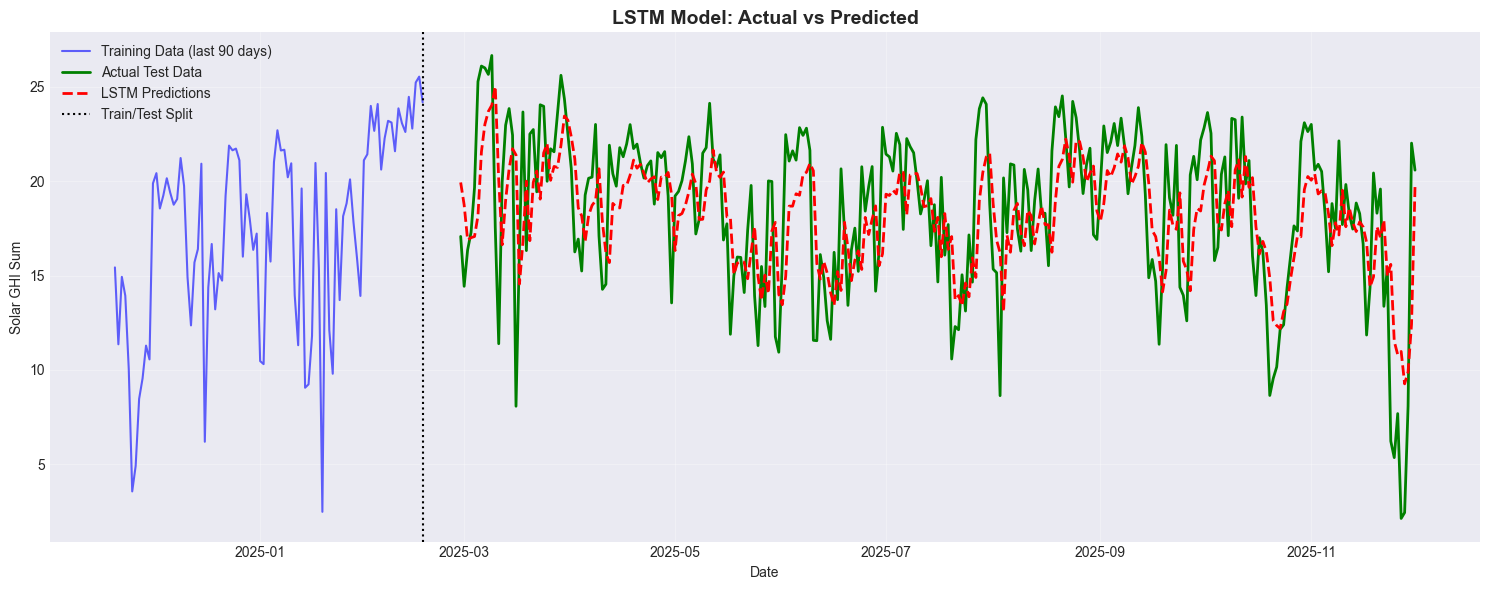

In [71]:
# Make predictions
model.eval()
with torch.no_grad():
    lstm_predictions_scaled = model(X_test_tensor).numpy()

# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate metrics
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
lstm_r2 = r2_score(y_test_actual, lstm_predictions)
lstm_mape = np.mean(np.abs((y_test_actual - lstm_predictions) / y_test_actual)) * 100
lstm_accuracy = 100 - lstm_mape

print("LSTM Model Performance:")
print(f"MAE:      {lstm_mae:.4f}")
print(f"RMSE:     {lstm_rmse:.4f}")
print(f"MAPE:     {lstm_mape:.2f}%")
print(f"Accuracy: {lstm_accuracy:.2f}%")
print(f"R² Score: {lstm_r2:.4f}")

# Plot predictions
test_dates = df.index[train_size + seq_length:]

plt.figure(figsize=(15, 6))
plt.plot(train_data.index[-90:], train_data[-90:], label='Training Data (last 90 days)', color='blue', alpha=0.6)
plt.plot(test_dates, y_test_actual, label='Actual Test Data', color='green', linewidth=2)
plt.plot(test_dates, lstm_predictions, label='LSTM Predictions', color='red', linewidth=2, linestyle='--')
plt.axvline(x=train_data.index[-1], color='black', linestyle=':', label='Train/Test Split')
plt.title('LSTM Model: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Solar GHI Sum')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Model Comparison


📊 MODEL ACCURACY COMPARISON
  Model      MAE     RMSE  MAPE (%)  Accuracy (%)
   LSTM 2.666135 3.371572 18.346503     81.653497
Prophet 3.426740 4.250950 24.325200     75.674800
 SARIMA 3.346100 4.144747 25.594422     74.405578

🏆 Best Model: LSTM
   Accuracy: 81.65%
   MAPE: 18.35%
   MAE: 2.6661


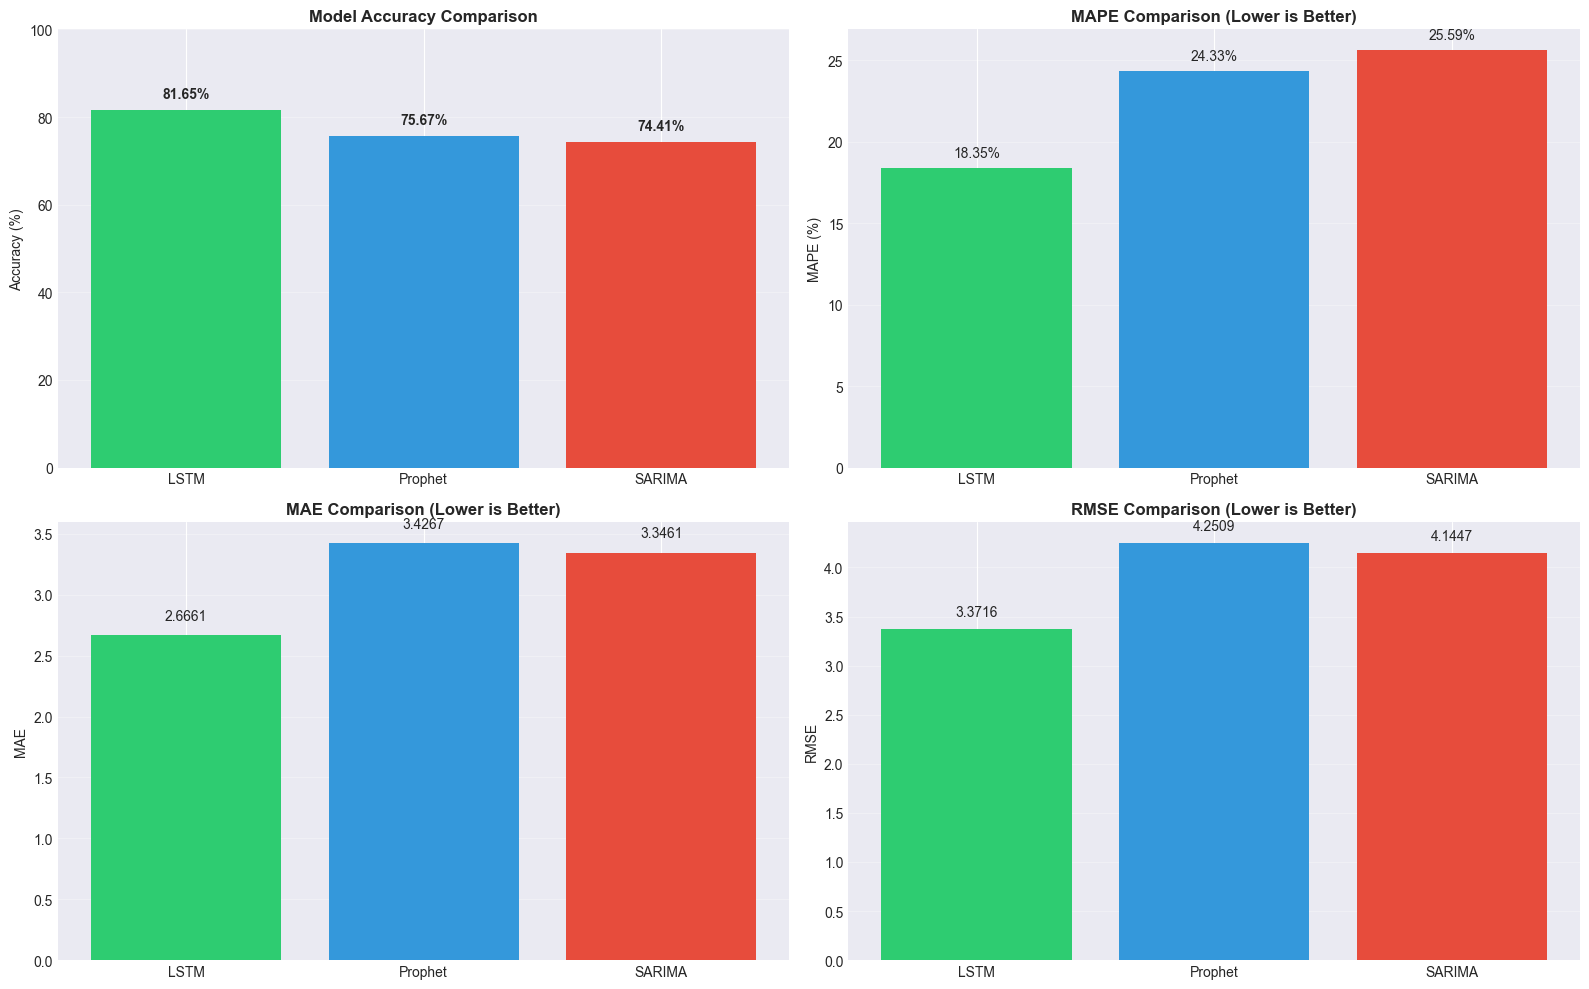

In [72]:
# Compare all models
comparison_data = {
    'Model': ['SARIMA', 'LSTM'],
    'MAE': [sarima_mae, lstm_mae],
    'RMSE': [sarima_rmse, lstm_rmse],
    'MAPE (%)': [sarima_mape, lstm_mape],
    'Accuracy (%)': [sarima_accuracy, lstm_accuracy]
}

if prophet_available:
    comparison_data['Model'].append('Prophet')
    comparison_data['MAE'].append(prophet_mae)
    comparison_data['RMSE'].append(prophet_rmse)
    comparison_data['MAPE (%)'].append(prophet_mape)
    prophet_accuracy = 100 - prophet_mape
    comparison_data['Accuracy (%)'].append(prophet_accuracy)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy (%)', ascending=False)

print("\n" + "="*70)
print("📊 MODEL ACCURACY COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)
print("\n🏆 Best Model: " + comparison_df.iloc[0]['Model'])
print(f"   Accuracy: {comparison_df.iloc[0]['Accuracy (%)']:.2f}%")
print(f"   MAPE: {comparison_df.iloc[0]['MAPE (%)']:.2f}%")
print(f"   MAE: {comparison_df.iloc[0]['MAE']:.4f}")
print("="*70)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Accuracy comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Accuracy (%)'], 
               color=['#2ecc71', '#3498db', '#e74c3c'][:len(comparison_df)])
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim([0, 100])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for j, (model, value) in enumerate(zip(comparison_df['Model'], comparison_df['Accuracy (%)'])):
    axes[0, 0].text(j, value + 2, f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: MAPE comparison (lower is better)
axes[0, 1].bar(comparison_df['Model'], comparison_df['MAPE (%)'], 
               color=['#2ecc71', '#3498db', '#e74c3c'][:len(comparison_df)])
axes[0, 1].set_title('MAPE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('MAPE (%)')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for j, (model, value) in enumerate(zip(comparison_df['Model'], comparison_df['MAPE (%)'])):
    axes[0, 1].text(j, value + 0.5, f'{value:.2f}%', ha='center', va='bottom')

# Plot 3: MAE comparison
axes[1, 0].bar(comparison_df['Model'], comparison_df['MAE'], 
               color=['#2ecc71', '#3498db', '#e74c3c'][:len(comparison_df)])
axes[1, 0].set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for j, (model, value) in enumerate(zip(comparison_df['Model'], comparison_df['MAE'])):
    axes[1, 0].text(j, value + 0.1, f'{value:.4f}', ha='center', va='bottom')

# Plot 4: RMSE comparison
axes[1, 1].bar(comparison_df['Model'], comparison_df['RMSE'], 
               color=['#2ecc71', '#3498db', '#e74c3c'][:len(comparison_df)])
axes[1, 1].set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for j, (model, value) in enumerate(zip(comparison_df['Model'], comparison_df['RMSE'])):
    axes[1, 1].text(j, value + 0.1, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()